https://ocw.mit.edu/courses/18-s096-topics-in-mathematics-with-applications-in-finance-fall-2013/3c8e688538b350a73a8c1cd46056fc5a_MIT18_S096F13_lecnote15.pdf

In [1]:
import pandas as pd
import numpy as np
import os
import datetime
import matplotlib.pyplot as plt

### Get data


In [2]:
df_agg = pd.read_parquet("../../data/data_agg_v0.parquet")

price_cols = [x for x in df_agg.columns if "LAST" in x]
df_subset = df_agg[["Date"] + price_cols[:12]]
df_subset.index = df_subset["Date"]
df_subset = df_subset.drop(columns=["Date"])
print(f"Shape before dropping nulls, {df_subset.shape}")
df_subset = df_subset.dropna()
print(f"Shape after dropping nulls, {df_subset.shape}")

Shape before dropping nulls, (5152, 12)
Shape after dropping nulls, (5148, 12)


<AxesSubplot: xlabel='Date'>

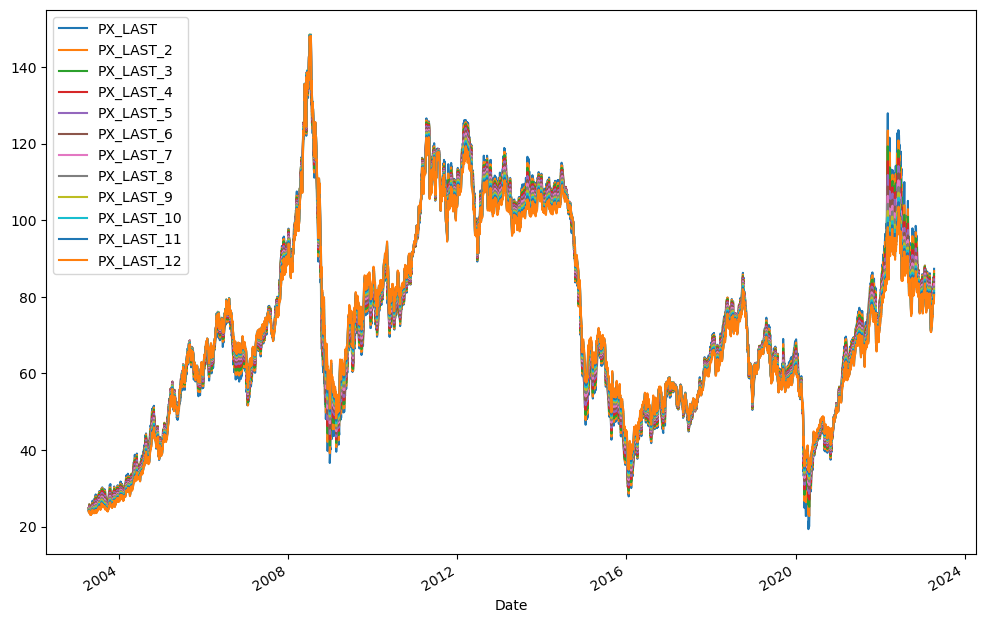

In [3]:
fig,ax = plt.subplots(figsize=(12,8))
df_subset.plot(ax=ax)

Text(0.5, 1.0, 'Log Returns')

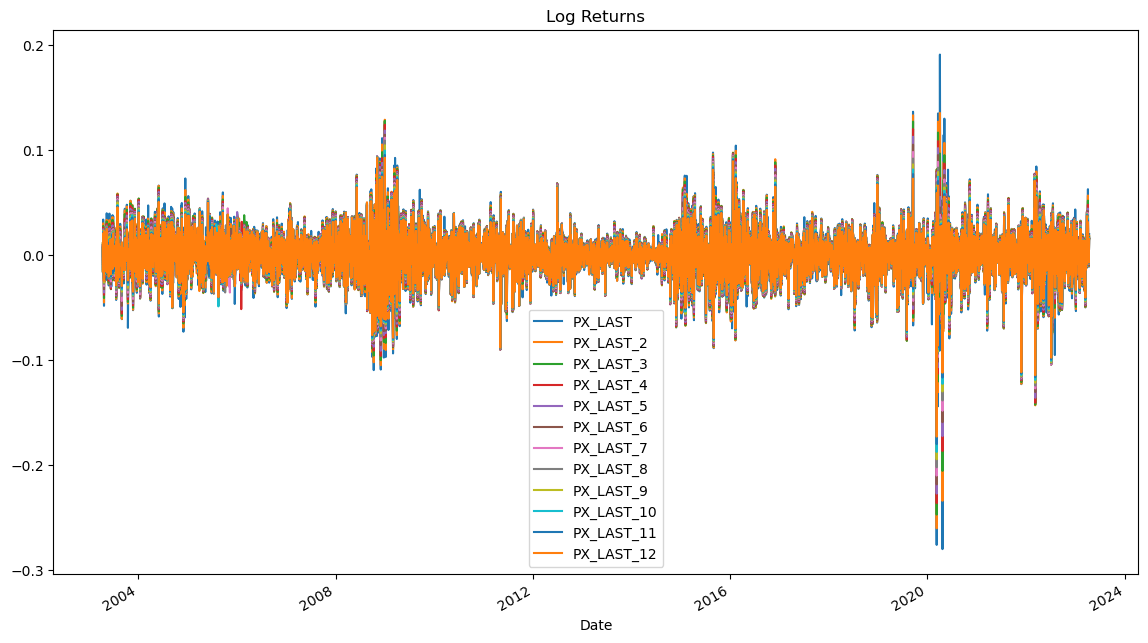

In [4]:
df_subset1 = df_subset.sort_index()
log_returns = np.log(df_subset1/df_subset1.shift(1)).dropna()
fig,ax = plt.subplots(figsize=(14,8))
log_returns.plot(ax=ax)
ax.set_title("Log Returns")

In [5]:
log_returns = log_returns[log_returns.index<="2010"]
log_returns.shape

(1719, 12)

### PCA

Text(0.5, 1.0, 'Corelation of log returns')

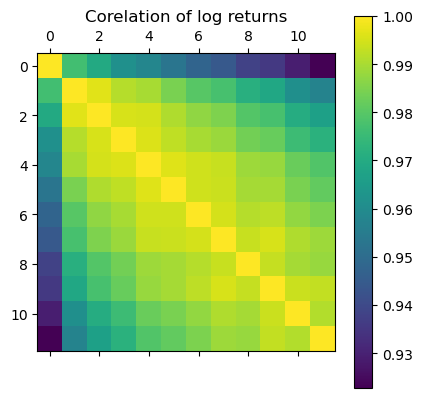

In [6]:
plt.matshow(log_returns.corr())
plt.colorbar()
plt.title("Corelation of log returns")

(1719, 12) (12,)
Singular values:  (1719, 1719) (12,) (12, 12)

Eigen values:  (12,) (12, 12)



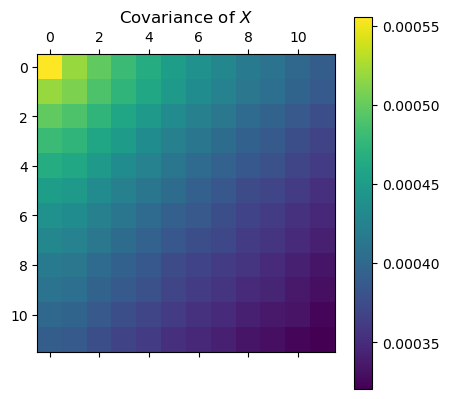

In [7]:
X = log_returns.values
X_mean = X.mean(axis=0)
print (X.shape,X_mean.shape)

N,M = X.shape

X_normalised = X-X_mean

cov = (X_normalised.T @ X_normalised)/(N)
plt.matshow(cov)
plt.colorbar()
plt.title("Covariance of $X$")

U,S,Vt = np.linalg.svd(X_normalised)
print ("Singular values: ",U.shape,S.shape,Vt.shape)
print()

e,e_vec=np.linalg.eigh(cov)
e = e[::-1]
e_vec = e_vec[:,::-1]
print ("Eigen values: ",e.shape,e_vec.shape)
print()

Text(0.5, 1.0, 'Eigen Values')

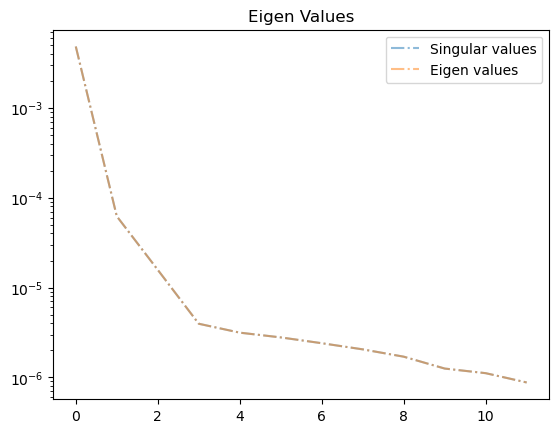

In [8]:
plt.semilogy(S**2/N,"-.", label = "Singular values",alpha=0.5)
plt.semilogy(e,"-.", label = "Eigen values",alpha=0.5)
plt.legend()
plt.title("Eigen Values")

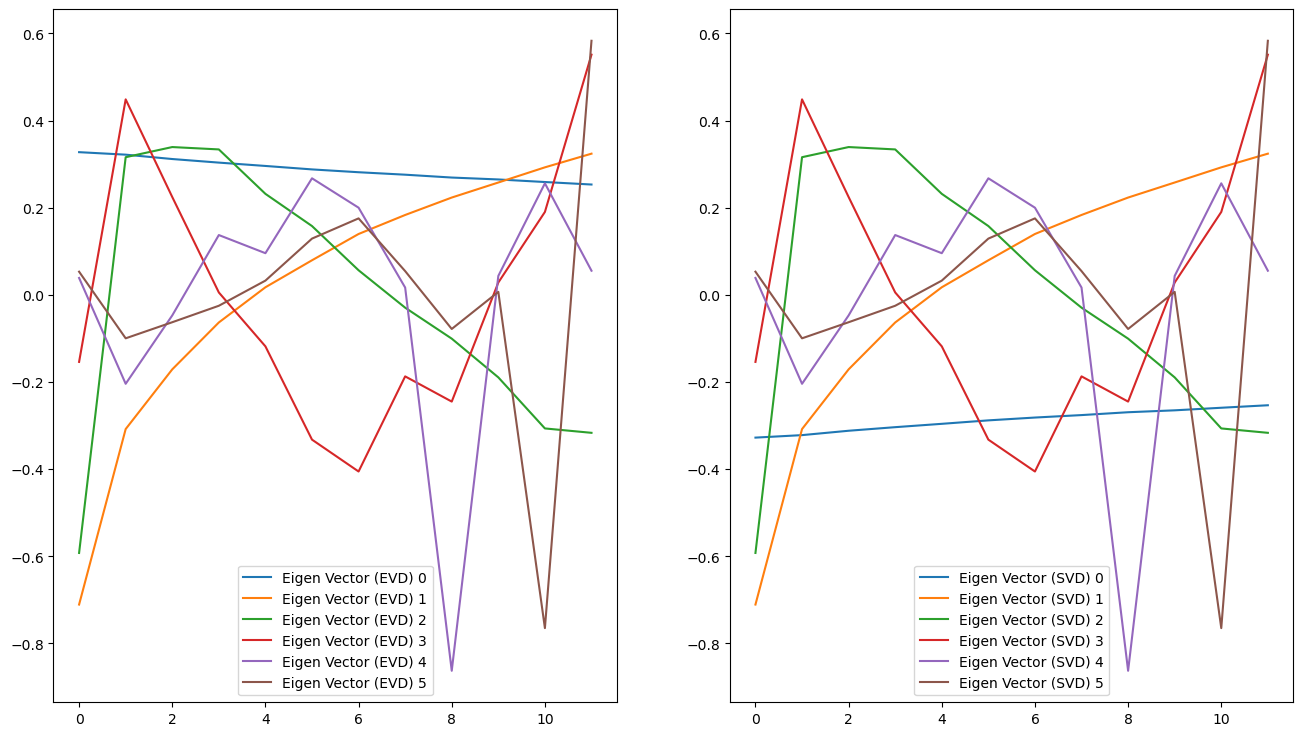

In [9]:
n_components = 6

fig,ax=plt.subplots(1,2,figsize=(16,9))
for i in range(n_components):
    ax[0].plot(e_vec[:,i], label=f"Eigen Vector (EVD) {i}")
    ax[1].plot(Vt.T[:,i], label=f"Eigen Vector (SVD) {i}")
ax[0].legend()
ax[1].legend()

In [11]:
e_vec.shape

(12, 12)

In [14]:
e_vec_df = pd.DataFrame(e_vec)
e_vec_df.index = log_returns.columns
e_vec_df.to_csv("../../data/eigen_vectors.csv",index=False)

#### Decomposed log returns 

In [29]:
log_returns_pca = pd.DataFrame(X@(Vt.T[:,:n_components]))
log_returns_pca.index = log_returns.index
log_returns_pca.columns = [f"pca_{i}" for i in range(n_components)]
log_returns_pca.index = log_returns.index
np.allclose(X@e_vec[:,:n_components],log_returns_pca.values)

False

In [30]:
log_returns_pca.to_csv("../../data/log_returns_pca.csv")

Text(0.5, 1.0, 'Log Returns (PCA-decomposed)')

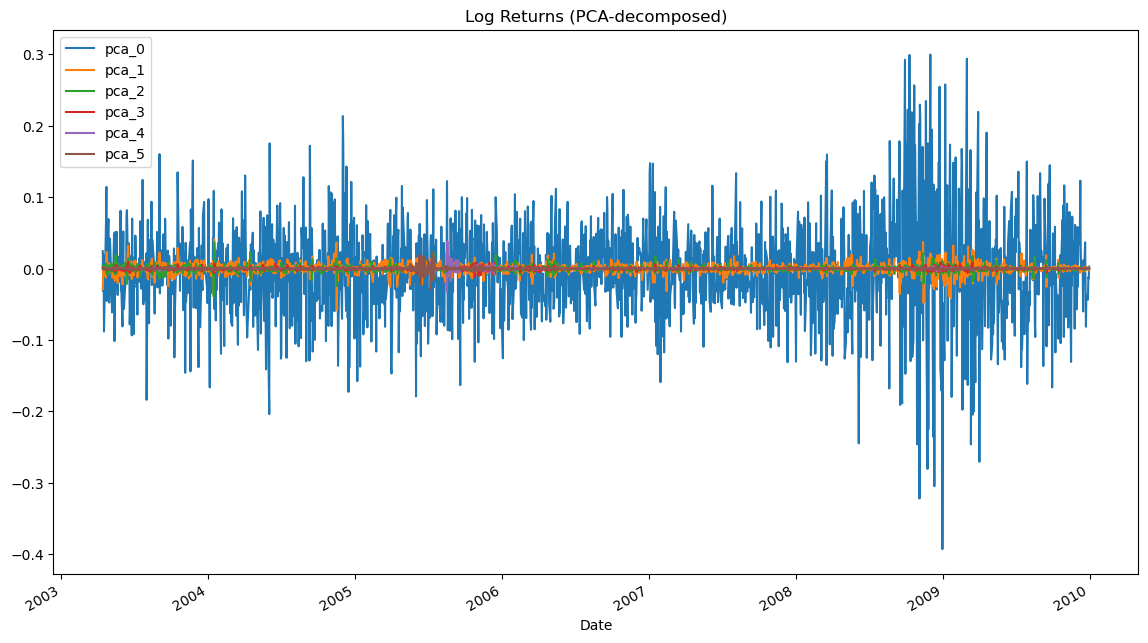

In [27]:
fig,ax = plt.subplots(figsize=(14,8))
log_returns_pca.plot(ax=ax)
ax.set_title("Log Returns (PCA-decomposed)")

### Compare with PCA

Text(0.5, 1.0, 'Log Returns check (PCA-decomposed)')

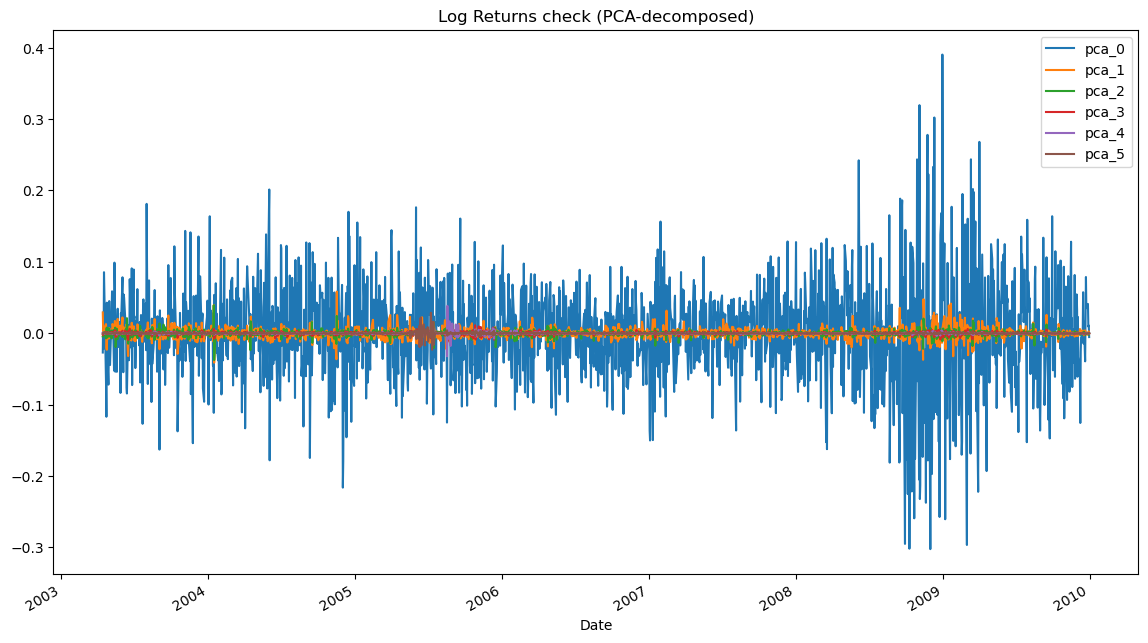

In [28]:
from sklearn.decomposition import PCA
pca = PCA(svd_solver="full",n_components=n_components)
pca.fit(log_returns)

log_returns_pca_check = pd.DataFrame(pca.transform(log_returns))
log_returns_pca_check.columns = [f"pca_{i}" for i in range(n_components)]
log_returns_pca_check.index = log_returns.index

fig,ax = plt.subplots(figsize=(14,8))
log_returns_pca_check.plot(ax=ax)
ax.set_title("Log Returns check (PCA-decomposed)")